<a href="https://colab.research.google.com/github/pravvvv/Amazon_fine_food_reviews/blob/main/Amazon_fine_food_reviews_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis




Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# Loading data

The dataset is available in two forms
1. .csv file
2. SQLite Database

SQLITE dataset was used to query the data 

We ensure the Score>3 is positive and Score<3 is set as negative . We ignore the score = 3

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import classification_report
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.preprocessing import normalize
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn import datasets, neighbors
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os

C:\Users\pmallya1\AppData\Local\Continuum\Anaconda3-5.2.0\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\pmallya1\AppData\Local\Continuum\Anaconda3-5.2.0\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#  Preprocessing

Steps planned for preprocessing:
* Remove html tags
* Remove punctuations, special characters
* Check for alpha numeric (avoid in most cases)
* Words have to be >2 length
* Convert to lowercase
* Remove stopwords
* Snowball Stemming

# Featurization

In [ ]:
#Dataset 100k points with only review text and summary

import pickle as pkl
with open(r"C:\Users\pmallya1\Documents\AI\Assign\preprocessing_svm_100k",'rb')  as f:
    ([X_train_ncv, X_cv, y_train_ncv, y_cv,X_test,y_test])=pkl.load(f)
    ([X_tr_bow,X_te_bow,X_cv_bow])=pkl.load(f)
    #([X_tr_bow_500,X_te_bow_500,X_cv_500])=pkl.load(f)
    ([X_tr_tfidf ,X_te_tdidf,X_cv_tdidf ])=pkl.load(f)
    #([X_tr_tfidf_500,X_te_tdidf_500,X_cv_tdidf_500])=pkl.load(f)
    ([X_tr_avgw2v,X_te_avgw2v,X_cv_avgw2v])=pkl.load(f)
    ([X_tr_tfidfw2v,X_cv_tfidfw2v,X_test_tfidfw2v])=pkl.load(f)



# Applying Decision Trees

In [ ]:
#normalize
   

def c_vs_AUC_CV_Train(depth_set,sample_split_list,mean_auc_train,mean_auc_cv):
        plt.plot(depth_set[:],mean_auc_train[0:],color='r', label='Train')
        plt.plot(depth_set[:],mean_auc_cv[0:],color='b', label='CV')
        plt.title("depth vs AUC" )
        plt.xlabel("depth")
        plt.ylabel("AUC")
        plt.legend()
        plt.ylim(0, 1)
        plt.show()
def LogReg_apply(test_c_set,X_tr,X_cv,y_tr,y_cv,pen):
    cv_scores = []
    mean_auc_train = []
    mean_auc_cv = []
    n = 10
    for c in tqdm(test_c_set):
        # for each iteration, randomly hold out 20% of the data as CV set
        clf = LogisticRegression(penalty=pen, C=c)
        clf.fit(X_tr, y_tr)
        pred_train = clf.predict_proba(X_tr)
        pred_cv = clf.predict_proba(X_cv)
        mean_auc_cv.append(roc_auc_score(y_cv, pred_cv[:,1]))
        mean_auc_train.append(roc_auc_score(y_tr, pred_train[:,1]))

    df = pd.DataFrame({
        'c' : test_c_set,
        'c Log' : np.log(test_c_set),
        'AUC_CV' : mean_auc_cv,
        'AUC_train' : mean_auc_train
    })
    return df
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc ,roc_auc_score

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
def DT_apply(X_tr,X_cv,y_tr,y_cv,X_te,y_test):
    #using Grid search
    import warnings
    warnings.filterwarnings('ignore')
    scaler = StandardScaler(with_mean=False)
    X_tr_sc = scaler.fit_transform(X_tr)
    X_cv_sc = scaler.transform(X_cv)    
    X_te_sc = scaler.transform(X_te)
    depths = [1, 5, 10, 14, 18, 20,24,28,32,36,40,44,50]
    s_list = [5, 10, 100, 500]
    #depths = [1, 5]
    #s_list = [5 ]
    
    parameter = {'max_depth': depths ,
                'min_samples_split' : s_list}
    print("Using Grid Search ...")
    
    clf = GridSearchCV(tree.DecisionTreeClassifier(class_weight="balanced"),parameter,verbose=1,scoring='roc_auc')
    clf.fit(X_tr_sc,y_tr)
    print("GridSearch completed..")
    opt_depth = clf.best_params_.get('max_depth')
    opt_sample_split = clf.best_params_.get('min_samples_split')
    mean_auc_train = clf.cv_results_.get('mean_train_score')
    mean_auc_cv = clf.cv_results_.get('mean_test_score')
    param_set = clf.cv_results_['params']
    print("Optimal max depth : ",opt_depth)
    print("Optimal min_samples_split : ",opt_sample_split)
    auc_cv = []
    auc_train = []
    for i in range(len(mean_auc_cv)):
        auc_cv.append(round(mean_auc_cv[i],2))
        auc_train.append(round(mean_auc_train[i],2))
    depth_list = []
    sample_split_list = []
    for i in param_set:
        depth_list.append(i['max_depth'])  
        sample_split_list.append(i['min_samples_split'])

    return(pd.DataFrame({
        'AUC CV' : auc_cv,
        'AUC Train' : auc_train,
        'Depth' : depth_list,
        'Sample Split' : sample_split_list
    }))
    

In [ ]:
#df_split_5 = df_DT[df_DT[min_sample_split==5]]
def plot_split_wise_graph(df_DT):
    clr_list = ['r','g','b','y']
    fig = plt.figure(figsize=(8,8))
    c=0
    for i in s_list:
        df_split = df_DT[df_DT['Sample Split']==i]
        plt.plot(df_split['Depth'],df_split['AUC Train'],clr_list[c], label='AUC_Train@Split:' + str(i))
        plt.plot(df_split['Depth'],df_split['AUC CV'],clr_list[c]+'--', label='AUC_CV@Split:' + str(i))
        c+=1
    plt.title("Depth vs AUC" )
    plt.xlabel("Depth")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid()
    plt.ylim(0, 1)
    plt.show()

In [ ]:
def test_results(opt_depth,opt_sample_split,X_tr,X_cv,y_tr,y_cv,X_te,y_test):
    import warnings
    warnings.filterwarnings('ignore')
    scaler = StandardScaler(with_mean=False)
    X_tr_sc = scaler.fit_transform(X_tr)
    X_cv_sc = scaler.transform(X_cv)    
    X_te_sc = scaler.transform(X_te)
    best_DT_model = tree.DecisionTreeClassifier(max_depth=opt_depth,
                                                min_samples_split=opt_sample_split,class_weight='balanced')
    best_DT_model.fit(X_tr_sc,y_tr)
    pred_tr = best_DT_model.predict_proba(X_tr_sc)
    pred_cv = best_DT_model.predict_proba(X_cv_sc)
    pred_te = best_DT_model.predict_proba(X_te_sc)
    fpr1, tpr1, thresholds = roc_curve(y_tr, pred_tr[:,1])
    fpr2, tpr2, thresholds = roc_curve(y_cv,  pred_cv[:,1])
    fpr3, tpr3, thresholds = roc_curve(y_test, pred_te[:,1])
    print("The AUC score for train data is : ",roc_auc_score(y_tr, pred_tr[:,1]))
    print("The AUC score for CV data is : ",roc_auc_score(y_cv,  pred_cv[:,1]))
    print("The AUC score for test data is : ",roc_auc_score(y_test, pred_te[:,1]))
    fig = plt.figure(figsize=(5,3))
    plt.plot(fpr1,tpr1,'r',label = 'Train data')
    plt.plot(fpr2,tpr2,'b',label = 'CV data')
    plt.plot(fpr3,tpr3,'g',label = 'Test data')
    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
    plt.show()
    import seaborn as sn
    #https://stackoverflow.com/questions/47264597/confusion-matrix-from-probabilities
    import matplotlib.pyplot as plt1
    y_pred = np.argmax(pred_te, axis=1)
    conf_mat = confusion_matrix(y_test, y_pred )
    conf_mat_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(figsize=(5,3))
    sn.heatmap(conf_mat , annot=True ,fmt='.1f' )
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print(classification_report(y_test, y_pred))
    #opt_row = df.loc[(df['Alpha set'] == opt_alpha) & (df['Penalty'] == opt_pen)]
    #plot graph between AUC CV and AUC Trainz

## Applying Decision Trees on BOW

In [ ]:
# Please write all the code with proper documentation

X_tr = X_tr_bow
X_te = X_te_bow
X_cv = X_cv_bow

df_DT = DT_apply(X_tr,X_cv,y_train_ncv,y_cv,X_te,y_test)
#X_tr,X_cv,y_tr,y_cv,X_te,y_test

Using Grid Search ...
Fitting 3 folds for each of 52 candidates, totalling 156 fits


[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed: 10.4min finished


GridSearch completed..
Optimal max depth :  28
Optimal min_samples_split :  500


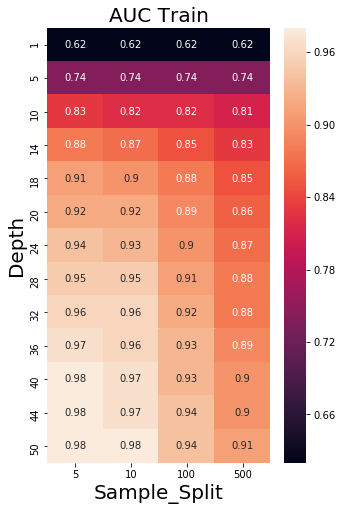

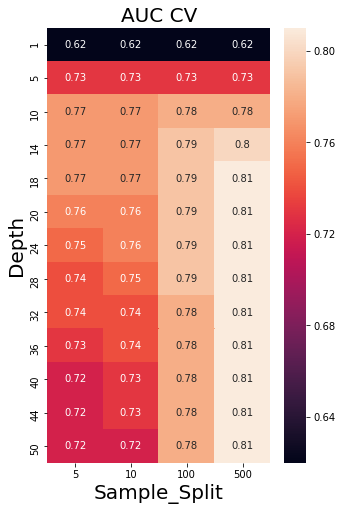

In [ ]:
#min sample split vs Depth
depths = [1, 5, 10, 14, 18, 20,24,28,32,36,40,44,50]
s_list = [5, 10, 100, 500]
df_sb = df_DT['AUC Train']
#df_depths 
df_hm = pd.DataFrame(df_sb.values.reshape(13,4), index=depths, columns=s_list )
fig = plt.figure(figsize=(5, 8))
heatmap = sns.heatmap(df_hm, annot=True)
plt. ylabel('Depth' , size=20)
plt. xlabel('Sample_Split' , size=20)
plt. title("AUC Train", size=20)
plt. show()    

#min sample split vs Depth
depths = [1, 5, 10, 14, 18, 20,24,28,32,36,40,44,50]
s_list = [5, 10, 100, 500]
df_sb = df_DT['AUC CV']
#df_depths 
df_hm = pd.DataFrame(df_sb.values.reshape(13,4), index=depths, columns=s_list )
fig = plt.figure(figsize=(5, 8))
heatmap = sns.heatmap(df_hm, annot=True)
plt. ylabel('Depth' , size=20)
plt. xlabel('Sample_Split' , size=20)
plt. title("AUC CV", size=20)
plt. show()    

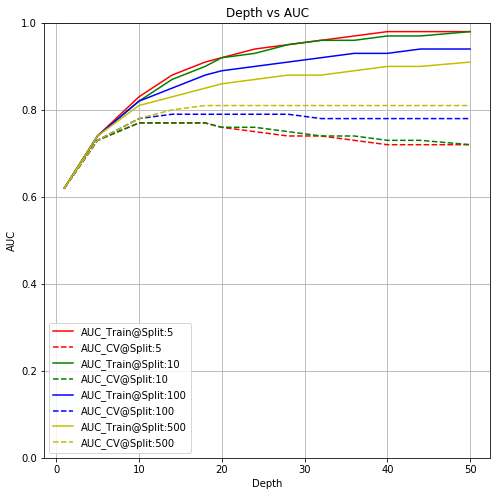

In [ ]:
plot_split_wise_graph(df_DT)


The AUC score for train data is :  0.8791291665096908
The AUC score for CV data is :  0.8159448100772044
The AUC score for test data is :  0.8181050677630264


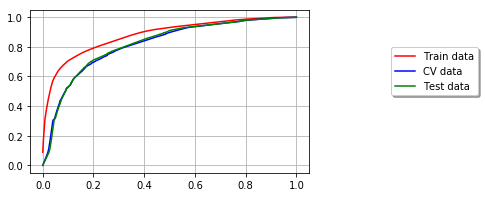

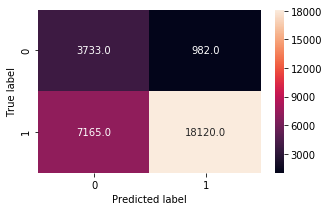

             precision    recall  f1-score   support

          0       0.34      0.79      0.48      4715
          1       0.95      0.72      0.82     25285

avg / total       0.85      0.73      0.76     30000



In [ ]:
opt_depth = 28
opt_sample_split = 500
test_results(opt_depth,opt_sample_split,X_tr,X_cv,y_train_ncv,y_cv,X_te,y_test)

### Top 20 important features from review text

In [ ]:
# Please write all the code with proper documentation
opt_depth = 28
opt_sample_split = 500
count_vect = CountVectorizer(min_df=10)  #in scikit-learn
X_tr = count_vect.fit_transform(X_train_ncv)
#X_te_bow = count_vect.transform(X_test)
feat = count_vect.get_feature_names()
best_DT_model = tree.DecisionTreeClassifier(max_depth=opt_depth,min_samples_split=opt_sample_split,class_weight='balanced')
best_DT_model.fit(X_tr, y_train_ncv)
#pred = best_DT_model.predict(X_te_bow)
feature_imp = best_DT_model.feature_importances_

df = pd.DataFrame({'coef' : feature_imp.T, 
                   'Feature names' : feat })

sorted_coef = df.sort_values(by = 'coef',kind = 'quicksort',ascending= False)
print("Top 20 important features : ")
print(list(sorted_coef['Feature names'][:20]))

Top 20 important features : 
['not', 'great', 'delicious', 'best', 'disappointed', 'love', 'good', 'perfect', 'loves', 'money', 'bad', 'favorite', 'excellent', 'thought', 'nice', 'wonderful', 'tasty', 'easy', 'worst', 'terrible']


### Graphviz visualization of Decision Tree on BOW

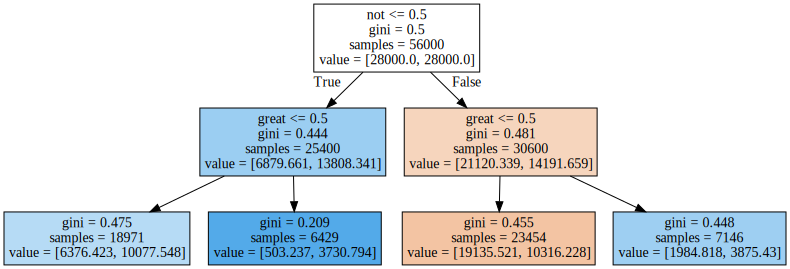

In [ ]:
import graphviz
count_vect = CountVectorizer(min_df=10)  #in scikit-learn
#opt_depth = 13
X_tr = count_vect.fit_transform(X_train_ncv)
feat = count_vect.get_feature_names()
#for visualization we print 3
best_DT_model = tree.DecisionTreeClassifier(max_depth=2,min_samples_split=500,class_weight='balanced')
best_DT_model.fit(X_tr, y_train_ncv)
export_graphviz(best_DT_model, out_file="mytree.dot",feature_names= feat, max_depth = 3, filled = True  )
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## Applying Decision Trees on TFIDF

In [ ]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
#X_tr_tfidf ,X_te_tdidf,X_cv_tdidf
X_tr = X_tr_tfidf
X_te = X_te_tdidf
X_cv = X_cv_tdidf

df_DT = DT_apply(X_tr,X_cv,y_train_ncv,y_cv,X_te,y_test)

Using Grid Search ...
Fitting 3 folds for each of 52 candidates, totalling 156 fits


[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed: 14.3min finished


GridSearch completed..
Optimal max depth :  32
Optimal min_samples_split :  500


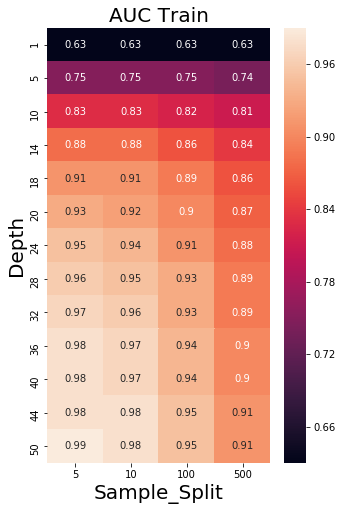

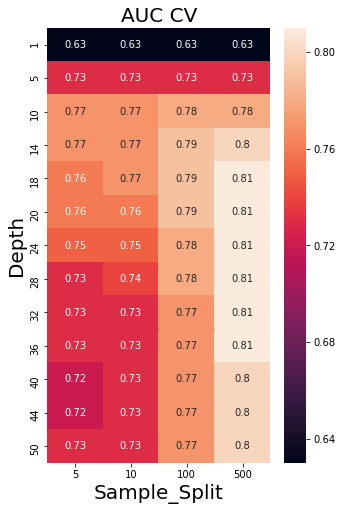

In [ ]:
#min sample split vs Depth
depths = [1, 5, 10, 14, 18, 20,24,28,32,36,40,44,50]
s_list = [5, 10, 100, 500]
df_sb = df_DT['AUC Train']
#df_depths 
df_hm = pd.DataFrame(df_sb.values.reshape(13,4), index=depths, columns=s_list )
fig = plt.figure(figsize=(5, 8))
heatmap = sns.heatmap(df_hm, annot=True)
plt. ylabel('Depth' , size=20)
plt. xlabel('Sample_Split' , size=20)
plt. title("AUC Train", size=20)
plt. show()    

#min sample split vs Depth
depths = [1, 5, 10, 14, 18, 20,24,28,32,36,40,44,50]
s_list = [5, 10, 100, 500]
df_sb = df_DT['AUC CV']
#df_depths 
df_hm = pd.DataFrame(df_sb.values.reshape(13,4), index=depths, columns=s_list )
fig = plt.figure(figsize=(5, 8))
heatmap = sns.heatmap(df_hm, annot=True)
plt. ylabel('Depth' , size=20)
plt. xlabel('Sample_Split' , size=20)
plt. title("AUC CV", size=20)
plt. show()    

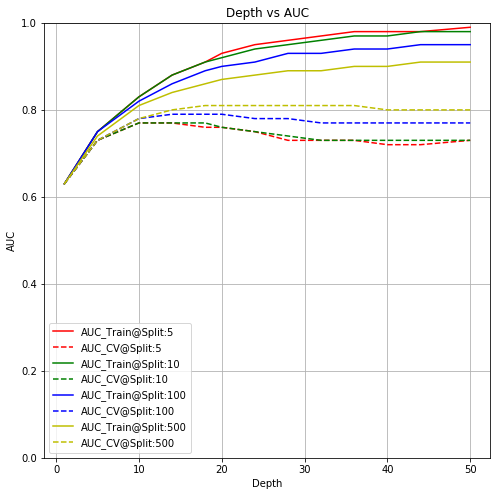

In [ ]:
plot_split_wise_graph(df_DT)


The AUC score for train data is :  0.8783469459331489
The AUC score for CV data is :  0.8161252491924446
The AUC score for test data is :  0.8220372630066028


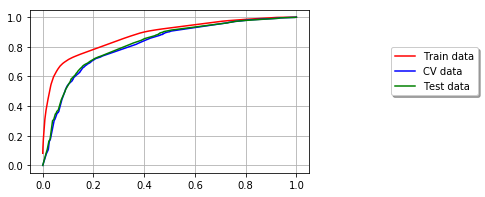

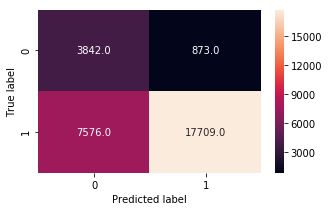

             precision    recall  f1-score   support

          0       0.34      0.81      0.48      4715
          1       0.95      0.70      0.81     25285

avg / total       0.86      0.72      0.76     30000



In [ ]:
opt_depth = 24
opt_sample_split = 500
test_results(opt_depth,opt_sample_split,X_tr,X_cv,y_train_ncv,y_cv,X_te,y_test)

### Top 20 important features from review text

In [ ]:
# Please write all the code with proper documentation

# Please write all the code with proper documentation

opt_depth = 24
opt_sample_split = 500
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 50  )
X_tr = tf_idf_vect.fit_transform(X_train_ncv)

#count_vect = CountVectorizer(min_df=10)  #in scikit-learn
#X_tr_bow = count_vect.fit_transform(X_train_ncv)
#X_te_bow = count_vect.transform(X_test)
feat = tf_idf_vect.get_feature_names()
best_DT_model = tree.DecisionTreeClassifier(max_depth=opt_depth,
                                            min_samples_split=opt_sample_split,class_weight='balanced')
best_DT_model.fit(X_tr, y_train_ncv)
#pred = best_DT_model.predict(X_te_bow)
feature_imp = best_DT_model.feature_importances_

df = pd.DataFrame({'coef' : feature_imp.T, 
                   'Feature names' : feat })

sorted_coef = df.sort_values(by = 'coef',kind = 'quicksort',ascending= False)
print("Top 20 important features : ")
print(list(sorted_coef['Feature names'][:20]))

Top 20 important features : 
['not', 'great', 'delicious', 'best', 'love', 'disappointed', 'good', 'perfect', 'loves', 'bad', 'money', 'excellent', 'favorite', 'wonderful', 'nice', 'not good', 'thought', 'easy', 'find', 'tasty']


### Graphviz visualization of Decision Tree on TFIDF

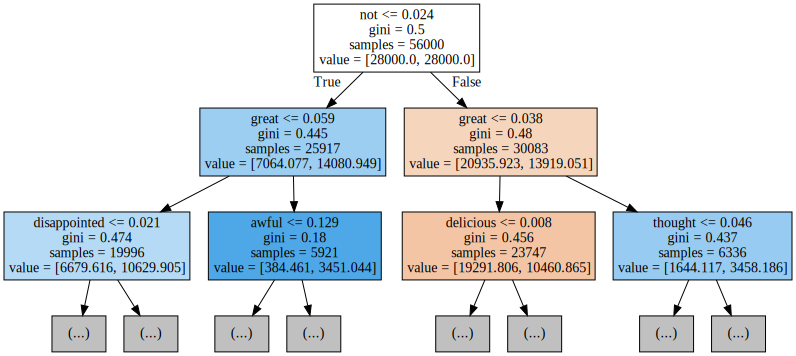

In [ ]:
# Please write all the code with proper documentation
import graphviz
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 50  )
X_tr = tf_idf_vect.fit_transform(X_train_ncv)
feat = tf_idf_vect.get_feature_names()
#for visualization we print 3
best_DT_model = tree.DecisionTreeClassifier(max_depth=3,min_samples_split=opt_sample_split,class_weight='balanced')
best_DT_model.fit(X_tr, y_train_ncv)
export_graphviz(best_DT_model, out_file="mytree.dot",feature_names= feat, max_depth = 2, filled = True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## Applying Decision Trees on AVG W2V

In [ ]:
# Please write all the code with proper documentation
X_tr = X_tr_avgw2v
X_te = X_te_avgw2v
X_cv = X_cv_avgw2v

df_DT = DT_apply(X_tr,X_cv,y_train_ncv,y_cv,X_te,y_test)

Using Grid Search ...
Fitting 3 folds for each of 52 candidates, totalling 156 fits


[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:  5.3min finished


GridSearch completed..
Optimal max depth :  10
Optimal min_samples_split :  500


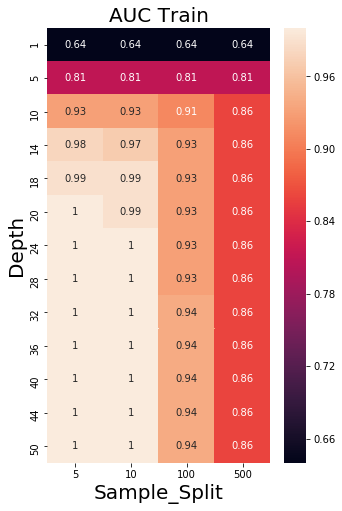

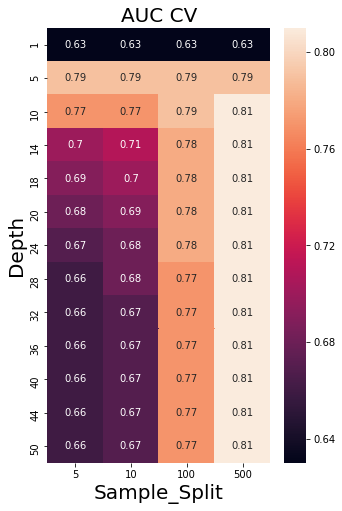

In [ ]:
#min sample split vs Depth
depths = [1, 5, 10, 14, 18, 20,24,28,32,36,40,44,50]
s_list = [5, 10, 100, 500]
df_sb = df_DT['AUC Train']
#df_depths 
df_hm = pd.DataFrame(df_sb.values.reshape(13,4), index=depths, columns=s_list )
fig = plt.figure(figsize=(5, 8))
heatmap = sns.heatmap(df_hm, annot=True)
plt. ylabel('Depth' , size=20)
plt. xlabel('Sample_Split' , size=20)
plt. title("AUC Train", size=20)
plt. show()    

#min sample split vs Depth
depths = [1, 5, 10, 14, 18, 20,24,28,32,36,40,44,50]
s_list = [5, 10, 100, 500]
df_sb = df_DT['AUC CV']
#df_depths 
df_hm = pd.DataFrame(df_sb.values.reshape(13,4), index=depths, columns=s_list )
fig = plt.figure(figsize=(5, 8))
heatmap = sns.heatmap(df_hm, annot=True)
plt. ylabel('Depth' , size=20)
plt. xlabel('Sample_Split' , size=20)
plt. title("AUC CV", size=20)
plt. show()    

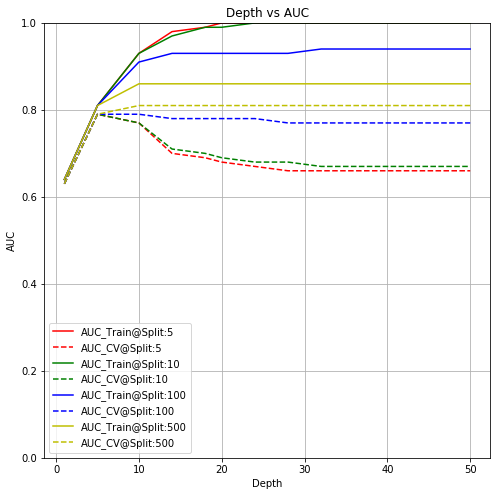

In [ ]:
plot_split_wise_graph(df_DT)

The AUC score for train data is :  0.8645380087636744
The AUC score for CV data is :  0.8163754759834989
The AUC score for test data is :  0.8193113333029969


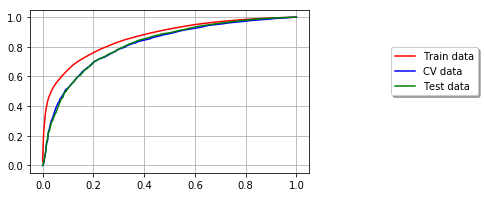

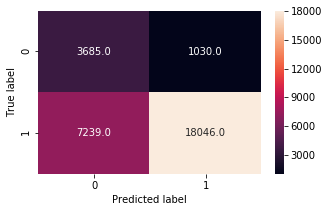

             precision    recall  f1-score   support

          0       0.34      0.78      0.47      4715
          1       0.95      0.71      0.81     25285

avg / total       0.85      0.72      0.76     30000



In [ ]:
opt_depth = 10
opt_sample_split = 500
test_results(opt_depth,opt_sample_split,X_tr,X_cv,y_train_ncv,y_cv,X_te,y_test)

## Applying Decision Trees on TFIDF W2V

In [ ]:
# Please write all the code with proper documentation
X_tr = X_tr_tfidfw2v
X_te = X_test_tfidfw2v
X_cv = X_cv_tfidfw2v

df_DT = DT_apply(X_tr,X_cv,y_train_ncv,y_cv,X_te,y_test)

Using Grid Search ...
Fitting 3 folds for each of 52 candidates, totalling 156 fits


[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:  5.4min finished


GridSearch completed..
Optimal max depth :  10
Optimal min_samples_split :  500


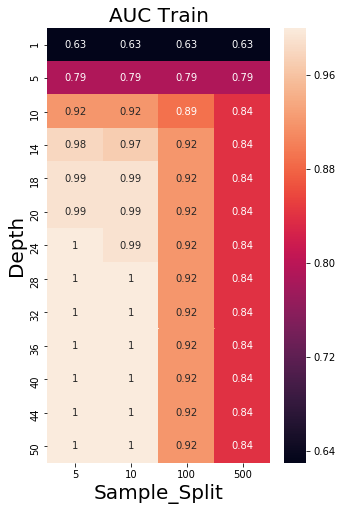

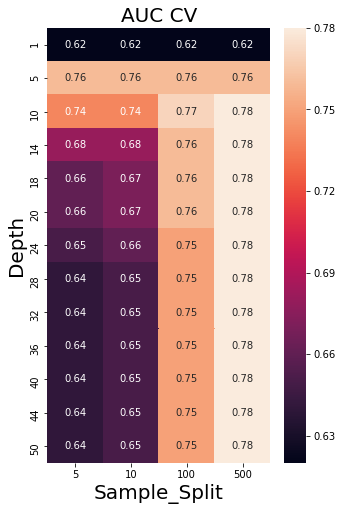

In [ ]:
#min sample split vs Depth
depths = [1, 5, 10, 14, 18, 20,24,28,32,36,40,44,50]
s_list = [5, 10, 100, 500]
df_sb = df_DT['AUC Train']
#df_depths 
df_hm = pd.DataFrame(df_sb.values.reshape(13,4), index=depths, columns=s_list )
fig = plt.figure(figsize=(5, 8))
heatmap = sns.heatmap(df_hm, annot=True)
plt. ylabel('Depth' , size=20)
plt. xlabel('Sample_Split' , size=20)
plt. title("AUC Train", size=20)
plt. show()    

#min sample split vs Depth
depths = [1, 5, 10, 14, 18, 20,24,28,32,36,40,44,50]
s_list = [5, 10, 100, 500]
df_sb = df_DT['AUC CV']
#df_depths 
df_hm = pd.DataFrame(df_sb.values.reshape(13,4), index=depths, columns=s_list )
fig = plt.figure(figsize=(5, 8))
heatmap = sns.heatmap(df_hm, annot=True)
plt. ylabel('Depth' , size=20)
plt. xlabel('Sample_Split' , size=20)
plt. title("AUC CV", size=20)
plt. show()    

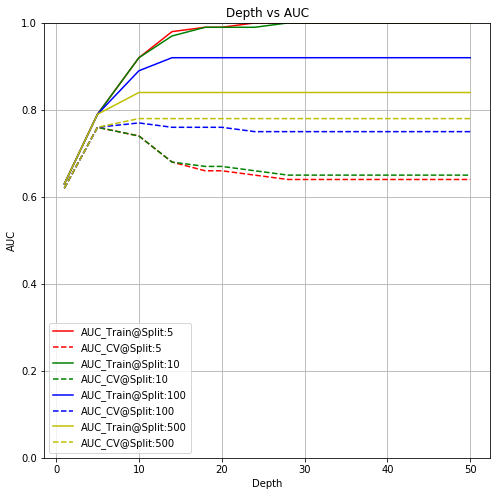

In [ ]:
plot_split_wise_graph(df_DT)

The AUC score for train data is :  0.842964113982537
The AUC score for CV data is :  0.7873228136441215
The AUC score for test data is :  0.7863010922566516


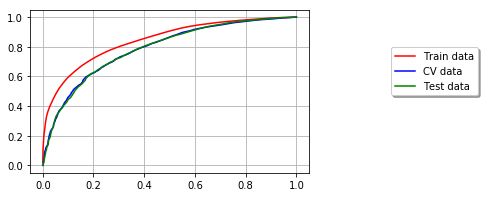

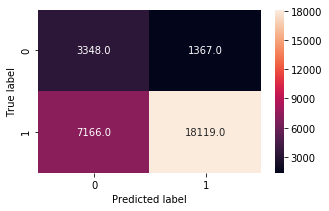

             precision    recall  f1-score   support

          0       0.32      0.71      0.44      4715
          1       0.93      0.72      0.81     25285

avg / total       0.83      0.72      0.75     30000



In [ ]:
opt_depth = 10
opt_sample_split = 500
test_results(opt_depth,opt_sample_split,X_tr,X_cv,y_train_ncv,y_cv,X_te,y_test)

# Observations

In [ ]:
from prettytable import PrettyTable


t= PrettyTable()

t.field_names =["Vectorization","Max depth" , "Sample Split",
                "AUC_Train","AUC_CV","AUC_Test"]
t.add_row(['BoW',28,500,0.88,0.82,0.82])
t.add_row(['TFIDF',24,500,0.88,0.82,0.82])
t.add_row(['AVG-W2V',10,500,0.86,0.82,0.82])
t.add_row(['TFIDF-W2V',10,500,0.84,0.79,0.79])
print(t)


+---------------+-----------+--------------+-----------+--------+----------+
| Vectorization | Max depth | Sample Split | AUC_Train | AUC_CV | AUC_Test |
+---------------+-----------+--------------+-----------+--------+----------+
|      BoW      |     28    |     500      |    0.88   |  0.82  |   0.82   |
|     TFIDF     |     24    |     500      |    0.88   |  0.82  |   0.82   |
|    AVG-W2V    |     10    |     500      |    0.86   |  0.82  |   0.82   |
|   TFIDF-W2V   |     10    |     500      |    0.84   |  0.79  |   0.79   |
+---------------+-----------+--------------+-----------+--------+----------+


1. We can see that the results are very close for CV and test data with vectorizations TFIDF , AVGw2v and tfidfw2v
2. In all cases sample split of 500 gave the best results 
3. Training accuracy is highest for Avg-w2V